# Voice assistant


## Loading packages
Use conda environment: *xtopia-voice*

### Imports

In [14]:
import pandas as pd
import numpy as np

import os
import sys

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import librosa
import librosa.display

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Activation
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
TF_ENABLE_ONEDNN_OPTS=0

In [15]:
from helpers.exploration_helpers import *
from helpers.preprocessing_helpers import *

In [16]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Functions

In [17]:
def load_RAVDESS(path:str) -> pd.core.frame.DataFrame:
    ravdess_directory_list = os.listdir(path)

    file_emotion = []
    file_path = []
    for dir in ravdess_directory_list:
        actor = os.listdir(path + dir)
        
        for file in actor:
            part = file.split('.')[0]
            part = part.split('-')
            try:
                file_emotion.append(int(part[2]))
                file_path.append(path + dir + '/' + file)
            except:
                pass
                #print(part) # Folders themself
            
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    path_df = pd.DataFrame(file_path, columns=['Path'])
    Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

    Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
    return Ravdess_df


In [18]:
def load_CREMA(path:str) -> pd.core.frame.DataFrame:
    crema_directory_list = os.listdir(path)

    file_emotion = []
    file_path = []

    for file in crema_directory_list:
        file_path.append(path + file)
        
        part=file.split('_')
        if part[0] == "AudioWAV":
            pass #print(part) #folder
        elif part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')
            
    emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

    path_df = pd.DataFrame(file_path, columns=['Path'])
    Crema_df = pd.concat([emotion_df, path_df], axis=1)
    return Crema_df

In [19]:
# def create_waveplot(data, sr, e):
#     plt.figure(figsize=(10, 3))
#     plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
#     librosa.display.waveshow(data, sr=sr)
#     plt.show()

# def create_spectrogram(data, sr, e):
#     X = librosa.stft(data)
#     Xdb = librosa.amplitude_to_db(abs(X))
#     plt.figure(figsize=(12, 3))
#     plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
#     librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
#     plt.colorbar()
    
# def noise(data):
#     noise_amp = 0.035*np.random.uniform()*np.amax(data)
#     data = data + noise_amp*np.random.normal(size=data.shape[0])
#     return data

# def stretch(data, rate=0.8):
#     return librosa.effects.time_stretch(data, rate)

# def shift(data):
#     shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
#     return np.roll(data, shift_range)

# def pitch(data, sampling_rate, pitch_factor=0.7):
#     return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)


In [20]:
# def extract_features(data, sample_rate):
#     # ZCR
#     result = np.array([])
#     zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
#     result=np.hstack((result, zcr)) # stacking horizontally

#     # Chroma_stft
#     stft = np.abs(librosa.stft(data))
#     chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
#     result = np.hstack((result, chroma_stft)) # stacking horizontally

#     # MFCC
#     mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
#     result = np.hstack((result, mfcc)) # stacking horizontally

#     # Root Mean Square Value
#     rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
#     result = np.hstack((result, rms)) # stacking horizontally

#     # MelSpectogram
#     mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
#     result = np.hstack((result, mel)) # stacking horizontally
    
#     return result

# def get_features(path):
#     # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
#     data, sample_rate = librosa.load(path, duration=2, offset=0.6, sr=8025)
    
#     # without augmentation
#     res1 = extract_features(data, sample_rate)
#     result = np.array(res1)
    
#     # data with noise
#     noise_data = noise(data)
#     res2 = extract_features(noise_data, sample_rate)
#     result = np.vstack((result, res2)) # stacking vertically
    
#     # data with stretching and pitching
#     new_data = stretch(data)
#     data_stretch_pitch = pitch(new_data, sample_rate)
#     res3 = extract_features(data_stretch_pitch, sample_rate)
#     result = np.vstack((result, res3)) # stacking vertically
    
#     return result

### Loading data

In [21]:
RAVDESS_PATH = "data/raw/RAVDESS/audio_speech_actors_01-24/"
CREMA_PATH = "data/raw/CREMA_D/AudioWAV/"

In [22]:
Ravdess_df = load_RAVDESS(RAVDESS_PATH)
Ravdess_df.head()

Emotions                                               Path
0  neutral  data/raw/RAVDESS/audio_speech_actors_01-24/Act...
1  neutral  data/raw/RAVDESS/audio_speech_actors_01-24/Act...
2  neutral  data/raw/RAVDESS/audio_speech_actors_01-24/Act...
3  neutral  data/raw/RAVDESS/audio_speech_actors_01-24/Act...
4     calm  data/raw/RAVDESS/audio_speech_actors_01-24/Act...

In [23]:
Crema_df = load_CREMA(CREMA_PATH)
Crema_df.head()

Emotions                                           Path
0    angry  data/raw/CREMA_D/AudioWAV/1001_DFA_ANG_XX.wav
1  disgust  data/raw/CREMA_D/AudioWAV/1001_DFA_DIS_XX.wav
2     fear  data/raw/CREMA_D/AudioWAV/1001_DFA_FEA_XX.wav
3    happy  data/raw/CREMA_D/AudioWAV/1001_DFA_HAP_XX.wav
4  neutral  data/raw/CREMA_D/AudioWAV/1001_DFA_NEU_XX.wav

In [24]:
# Join dataframes
data_path = pd.concat([Ravdess_df], axis = 0)
#data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  neutral  data/raw/RAVDESS/audio_speech_actors_01-24/Act...
1  neutral  data/raw/RAVDESS/audio_speech_actors_01-24/Act...
2  neutral  data/raw/RAVDESS/audio_speech_actors_01-24/Act...
3  neutral  data/raw/RAVDESS/audio_speech_actors_01-24/Act...
4     calm  data/raw/RAVDESS/audio_speech_actors_01-24/Act...

In [25]:
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### Waveforms

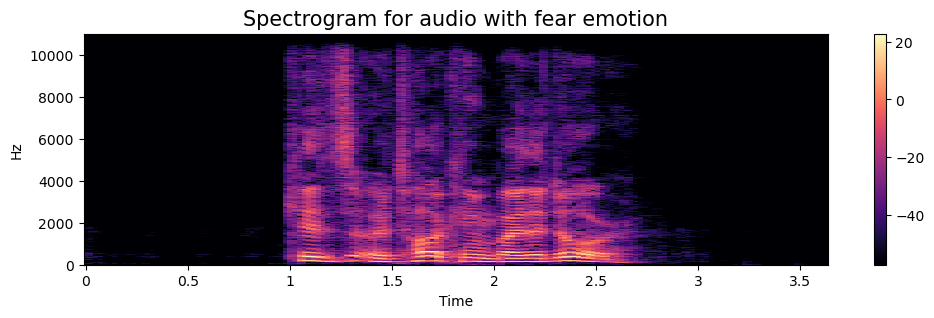

In [26]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

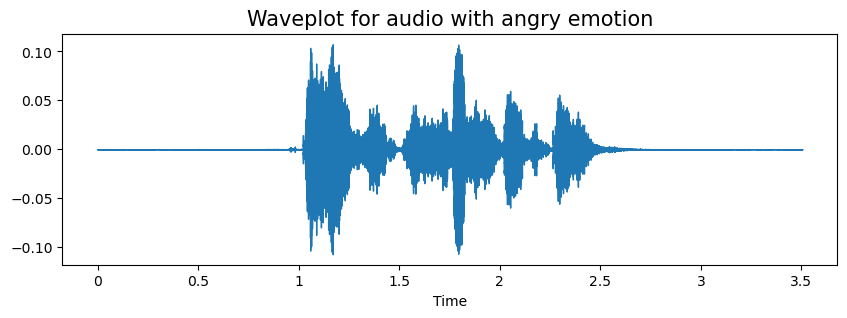

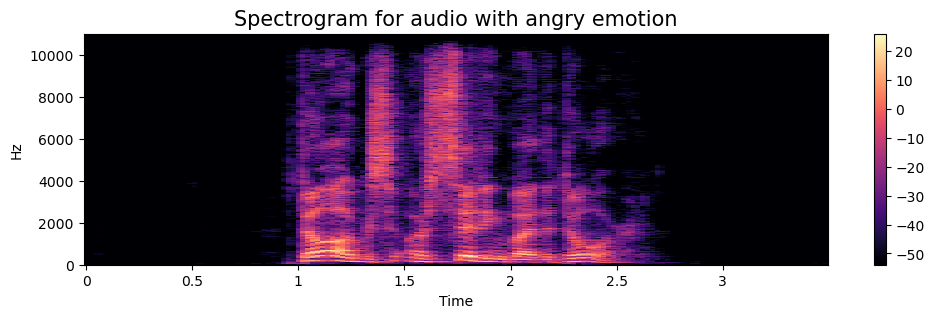

In [27]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

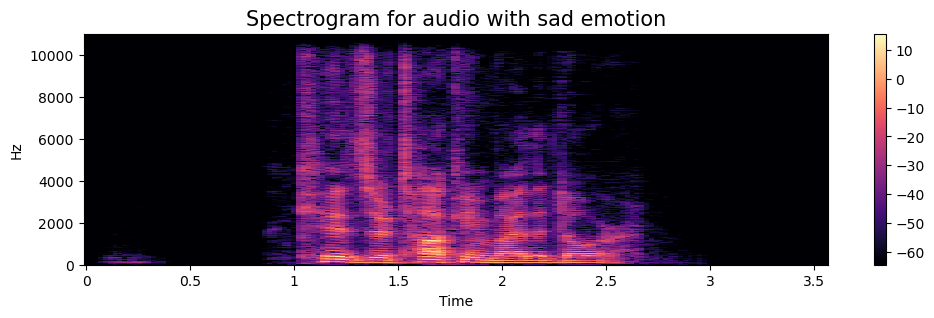

In [28]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

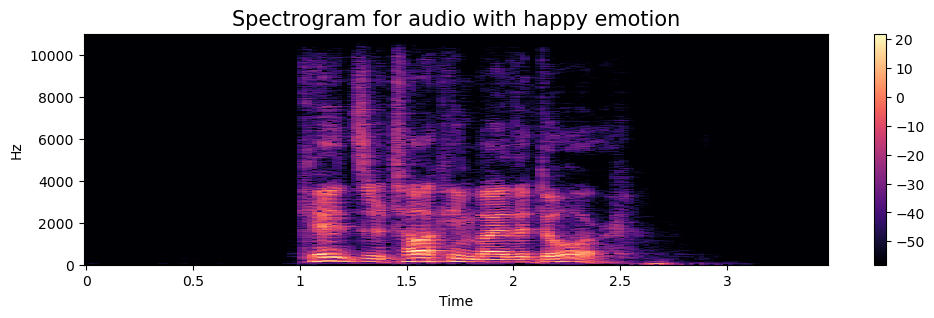

In [29]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

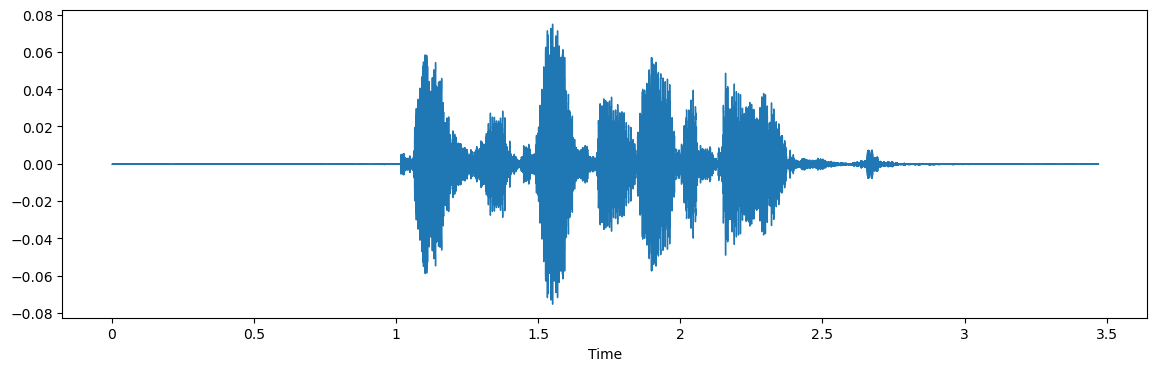

In [30]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

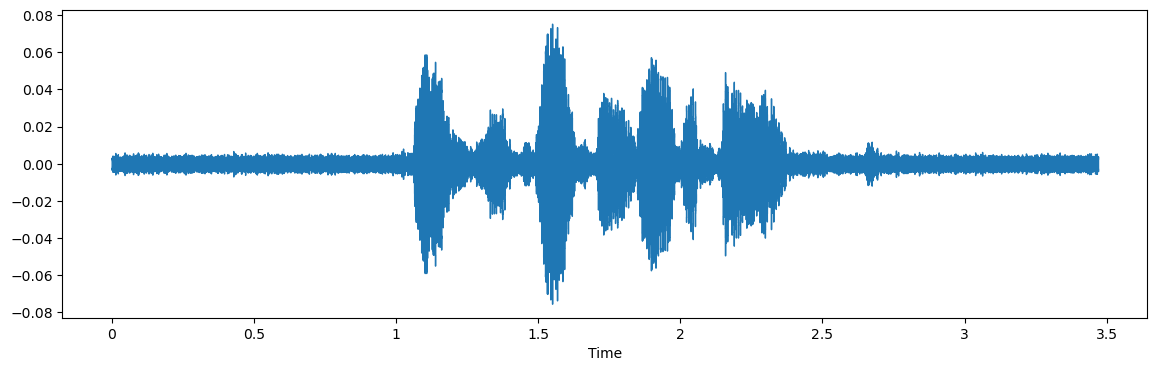

In [31]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

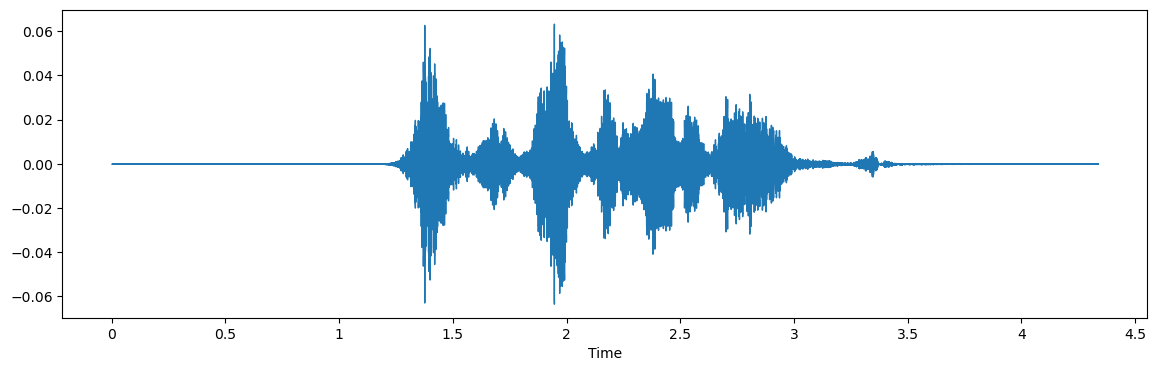

In [32]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [33]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

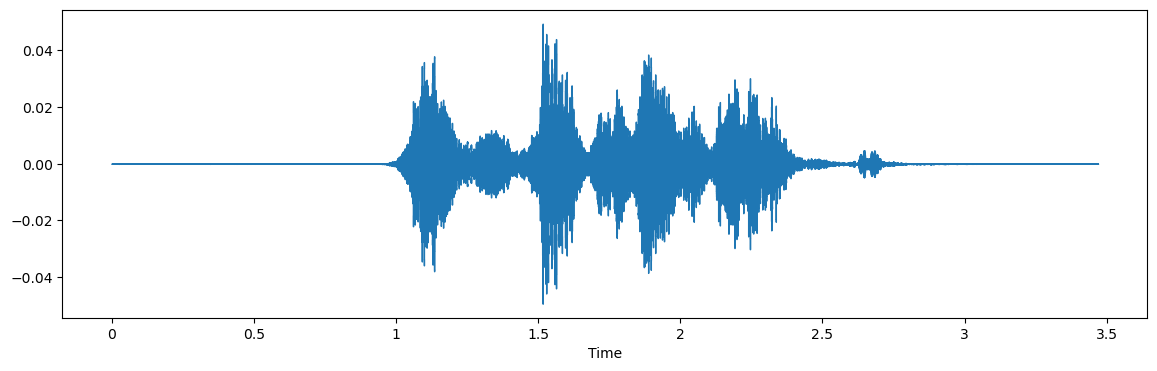

In [34]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

### Feature extraction

In [35]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    #print(path)
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

KeyboardInterrupt: 

In [ ]:
len(X), len(Y), data_path.Path.shape

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape